In [1]:
import numpy as np
import MDAnalysis as mda
import matplotlib.pyplot as plt
import MDAnalysis.analysis.distances
import networkx as nx
import scipy.stats as stats
from itertools import product as product

In [2]:
u=mda.Universe('traj/ring/last_200ns.gro','traj/ring/last_200ns.xtc')

In [2]:
u=mda.Universe('/Users/rmz/Downloads/c_90.pdb')

In [3]:
def find_largest_cluster(u,
                      frame,
                      selection,
                      cutoff_distance=10, 
                      cluster_atoms=False): #name of single atom
    
    u.trajectory[frame]
    
    polymers=u.select_atoms(selection)
    
    if  cluster_atoms==False:
        cluster_atoms='name '+(polymers.atoms.names[0]) 
    else:
        pass    
    
    cluster_atoms_sel = polymers.select_atoms(cluster_atoms)

    dist_array=MDAnalysis.analysis.distanices.contact_matrix(cluster_atoms_sel.atoms.positions,
                                                            cutoff=cutoff_distance,
                                                            box=u.dimensions)

    G = nx.from_numpy_matrix(dist_array)
    clusters=[h for h in nx.connected_components(G)]
    
    for c in clusters:
        if len(c)==max([len(c_) for c_ in clusters]):
            largest_cluster_resids = [i+1 for i in  c]
            
#     clusters = []
#     for c in clusters:
#         if len(c)>min_cluster_size:
#             clusters.append( [i+1 for i in  c])
            
    return largest_cluster_resids

In [21]:
def make_cluster_whole(u,
                       frame,
                       cluster_resids,
                       core_selection,  #need to add  -> easier to do it now
                       shell_selection, #need to add- > easier to do it now 
                       solvent=False): 
    u.trajectory[frame]
    
    cluster_sel = u.select_atoms('resid '+" ".join([str(i) for i in cluster_resids]))
    core_sel = u.select_atoms(core_selection).select_atoms('resid '+" ".join([str(i) for i in cluster_resids]))
    shell_sel = u.select_atoms(shell_selection).select_atoms('resid '+" ".join([str(i) for i in cluster_resids]))
    
    cluster_atoms_positions=cluster_sel.positions.copy()
    core_sel_atoms_positions=core_sel.positions.copy()
    shell_sel_atoms_positions=shell_sel.positions.copy()
    


        
    box=u.dimensions

    for dimension in range(0,3):

        y = stats.binned_statistic(cluster_sel.positions[:,dimension],
                                     cluster_sel.positions[:,dimension],
                                     bins=np.arange(-50,box[0]+50,10),
                                     statistic='count').statistic

        a = stats.binned_statistic(cluster_sel.positions[:,dimension],
                                   cluster_sel.positions[:,dimension],
                                   bins=np.arange(-50,box[0]+50,10),
                                   statistic='count').bin_edges

        move_above=False
        move_water=False

        filled=np.where(y!=0)[0]

        for i in range(len(filled)-1):
            if filled[i]!=filled[i+1]-1:
                move_above = a[filled[i+1]]
                move_lower_bound=a[filled[i]]
                move_water=(move_lower_bound+move_above)/2
        ####

        if move_above!=False:
            for atom in range(len(cluster_atoms_positions)):
                if cluster_atoms_positions[atom][dimension]>move_above:
                    cluster_atoms_positions[atom][dimension]=cluster_atoms_positions[atom][dimension]-box[dimension]

            for atom in range(len(core_sel_atoms_positions)):
                if core_sel_atoms_positions[atom][dimension]>move_above:
                    core_sel_atoms_positions[atom][dimension]=core_sel_atoms_positions[atom][dimension]-box[dimension]
            
            if solvent==False:

                for atom in range(len(shell_sel_atoms_positions)):
                    if shell_sel_atoms_positions[atom][dimension]>move_above:
                        shell_sel_atoms_positions[atom][dimension]=shell_sel_atoms_positions[atom][dimension]-box[dimension]


        if solvent!=False:
            for atom in range(len(shell_sel_atoms_positions)):
                if shell_sel_atoms_positions[atom][dimension]>move_water:
                    shell_sel_atoms_positions[atom][dimension]=shell_sel_atoms_positions[atom][dimension]-box[dimension]
        else:
            solvent_atoms_positions=0
            
            
    return cluster_atoms_positions,core_sel_atoms_positions,shell_sel_atoms_positions,solvent_atoms_positions




In [5]:

def cartesian_to_spherical(xyz):
    ptsnew = np.hstack((xyz, np.zeros(xyz.shape)))
    xy = xyz[:,0]**2 + xyz[:,1]**2
    ptsnew[:,3] = np.sqrt(xy + xyz[:,2]**2)
    ptsnew[:,4] = np.arctan2(np.sqrt(xy), xyz[:,2]) # for elevation angle defined from Z-axis down
    #ptsnew[:,4] = np.arctan2(xyz[:,2], np.sqrt(xy)) # for elevation angle defined from XY-plane up
    ptsnew[:,5] = np.arctan2(xyz[:,1], xyz[:,0])
    return ptsnew


In [7]:
def spherical_intrinsic_density(u,
                                frame=-1,
                                no_bins=31,
                                cluster_resids,
                                cluster_atoms_positions=cluster_atoms_positions,
                                core_sel_atoms_positions=core_sel_atoms_positions,
                                shell_sel_atoms_positions=shell_sel_atoms_positions,
                                no_random_points=10000,
                                normalisation_run=False):
    
  #  no_bins=31 #this actually gives (N-1)**2 bins (this is the number of edges in 1D)
    u.trajectory[frame]
    box_=u.dimensions
    
    cluster_sel = u.select_atoms('resid '+" ".join([str(i) for i in cluster_resids]))
    
    com = sum([(1/(sum(cluster_sel.masses)))*cluster_sel.masses[i]*cluster_atoms_positions[i] for i in range(len(cluster_sel))])
#     print(com)
    ####calc spherical polars of core
    core_array = cartesian_to_spherical(core_sel_atoms_positions-com)
    
    r_core_tmp=core_array[:,3]
    theta_core_tmp=core_array[:,4]
    phi_core_tmp=core_array[:,5]

#     r_core_sphere = [i for i in r_core_tmp]
#     theta_core_sphere=[i for i in theta_core_tmp]
#     phi_core_sphere=[i for i in phi_core_tmp]
    
    ####calc spherical polars of shell
    
    if normalisation_run == False:
        shell_array = cartesian_to_spherical(shell_sel_atoms_positions-com)
        
    elif normalisation_run == True:
        shell_array = cartesian_to_spherical(np.random.uniform(-u.dimensions[0]/2,u.dimensions[0]/2,size=(no_random_points,3)))
    
    r_shell_sphere_tmp=shell_array[:,3]
    theta_shell_sphere_tmp=shell_array[:,4]
    phi_shell_sphere_tmp=shell_array[:,5]

#     r_shell_sphere = [i for i in r_shell_sphere_tmp]
#     theta_shell_sphere=[i for i in theta_shell_sphere_tmp]
#     phi_shell_sphere=[i for i in phi_shell_sphere_tmp]
    
    ###calc shell bins
    
    shell_pos=stats.binned_statistic_2d([np.cos(i) for i in theta_shell_sphere_tmp],phi_shell_sphere_tmp,r_shell_sphere_tmp,bins=[np.linspace(-1,1,no_bins),np.linspace(-np.pi,np.pi,no_bins)],expand_binnumbers=True,statistic='count')


    ####calc interface positions
    
    interface=stats.binned_statistic_2d([np.cos(i) for i in theta_core_tmp],phi_core_tmp,r_core_tmp,bins=[np.linspace(-1,1,no_bins),np.linspace(-np.pi,np.pi,no_bins)],expand_binnumbers=True,statistic=np.max)###np.max finds edge of core!

    interface_vals=interface.statistic.copy()


    while np.count_nonzero(~np.isnan(interface_vals))!=(len(np.linspace(0,box_[0],num=no_bins))-1)*(len(np.linspace(0,box_[0],num=no_bins))-1):
        for i in range(len(interface_vals)):
            for j in range(len(interface_vals)):

                if np.isnan(interface_vals[i][j]):
                    n_i=[i-1,i,i+1]
                    n_j=[j-1,j,j+1]
                    interface_vals[i][j]=np.nanmean([interface_vals[divmod(ip,len(interface_vals))[1]][divmod(jp,len(interface_vals))[1]] for ip,jp in product(n_i,n_j)])


    intrinsic_r,spherical_r = [],[]

    for i in range(len(r_shell_sphere_tmp)):
        bin_X=shell_pos.binnumber[0][i]-1
        bin_Y=shell_pos.binnumber[1][i]-1


        interface_pos=interface_vals[bin_X][bin_Y]
        intrinsic_r.append(-interface_pos+r_shell_sphere_tmp[i])
        spherical_r.append(r_shell_sphere_tmp[i])
        
    
    
    return intrinsic_r,spherical_r,np.mean(interface_vals),np.std(interface_vals)


SyntaxError: non-default argument follows default argument (700806580.py, line 5)

In [29]:
largest_cluster_resids = find_largest_cluster(u,-1,'resname LIG',
                                              cutoff_distance=15,
                                              cluster_atoms=False)

print('Molecules in largest cluster identified: '+str(len(largest_cluster_resids)))

Molecules in largest cluster identified: 16


In [144]:

eo_o_names = 'name '+' '.join(str(i) for i in ['O009','O008', 'O007', 'O006', 'O005',  'O004' , 'O003',  'O002', 'O001',  'O000',  'O00F',  'O00G','O00H', 'O00I',  'O00J' ,'O00L', 'O00K', 'O00M' ,'O00N' , 'O00O', 'O00P', 'O00Q' , 'O00R', 'O00S' ,'O00T' , 'O00U', 'O00V',  'O00W' , 'O00X', 'O00Y','O011','9C02', 'C01Z', 'C01X', 'C01V', 'C01T', 'C01R', 'C01P', 'C01N', 'C01L', 'C01J', 'C01H', 'C01F', 'C01D', 'C01B', '7C01',
            '9C01', '5C01', '3C01', '1C01', 'C00Z', 'C00X', '1C00','3C00', '5C00', '7C00', '9C00', 'C00B', 'C00D', 'C00F', 'C00H', 'C00J' ])

ma_o_names = 'name '+' '.join(str(i) for i in  ['O012', 'O010', 'O015', 'O016', 'O019', 'O01A', 'O01D', 'O01F', 'O01G', 'O00C', 'O00D', 'O00A','8C02', '4C02', '2C02', 'C02E', 'C02I', 'C02M', 'C02Q', 'C02U', 'C02Y', 'C00S', 'C00Q', 'C00M' ])

cluster_atoms_positions,core_sel_atoms_positions,shell_sel_atoms_positions,solvent_atoms_positions,solute_atoms_positions = make_cluster_whole(u,
                                                                                            ts=-1,
                                                                                           cluster_resids = largest_cluster_resids,
                                                                                            core_selection=ma_o_names,
                                                                                            shell_selection=eo_o_names)



In [30]:

cluster_atoms_positions,core_sel_atoms_positions,shell_sel_atoms_positions,solvent_atoms_positions = make_cluster_whole(u,
                                                                                            frame=0,
                                                                                           cluster_resids = largest_cluster_resids,
                                                                                            core_selection='all',
                                                                                            shell_selection='all')


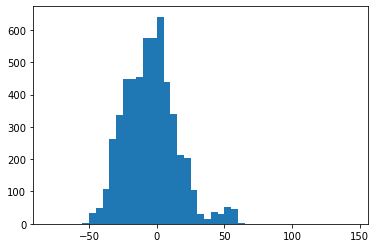

TypeError: unsupported operand type(s) for /: 'list' and 'int'

In [44]:
plt.hist(cluster_atoms_positions[:,1],bins=np.arange(-80,150,5))
plt.show()
z=mda.Universe.empty(len(u.atoms)*largest_cluster_resids/20),16)
z.add_TopologyAttr('names',u.atoms.names)
z.load_new(cluster_atoms_positions)

In [198]:
intrinsic_r_,norm_intrinsic_r_,core_rad_ =[],[],[]

eo_o_names = 'name '+' '.join(str(i) for i in ['O009','O008', 'O007', 'O006', 'O005',  'O004' , 'O003',  'O002', 'O001',  'O000',  'O00F',  'O00G','O00H', 'O00I',  'O00J' ,'O00L', 'O00K', 'O00M' ,'O00N' , 'O00O', 'O00P', 'O00Q' , 'O00R', 'O00S' ,'O00T' , 'O00U', 'O00V',  'O00W' , 'O00X', 'O00Y','O011','9C02', 'C01Z', 'C01X', 'C01V', 'C01T', 'C01R', 'C01P', 'C01N', 'C01L', 'C01J', 'C01H', 'C01F', 'C01D', 'C01B', '7C01',
            '9C01', '5C01', '3C01', '1C01', 'C00Z', 'C00X', '1C00','3C00', '5C00', '7C00', '9C00', 'C00B', 'C00D', 'C00F', 'C00H', 'C00J' ])

ma_o_names = 'name '+' '.join(str(i) for i in  ['O012', 'O010', 'O015', 'O016', 'O019', 'O01A', 'O01D', 'O01F', 'O01G', 'O00C', 'O00D', 'O00A','8C02', '4C02', '2C02', 'C02E', 'C02I', 'C02M', 'C02Q', 'C02U', 'C02Y', 'C00S', 'C00Q', 'C00M' ])

for t in range(1,5,1):
    
    largest_cluster_resids = find_largest_cluster(u,-t,'resname LIG',
                                              cutoff_distance=20,
                                              cluster_atoms=False)

    
    print('Molecules in largest cluster identified: '+str(len(largest_cluster_resids)))
    

    cluster_atoms_positions,core_sel_atoms_positions,shell_sel_atoms_positions,solvent_atoms_positions,solute_atoms_positions = make_cluster_whole(u,
                                                                                            ts=-t,
                                                                                           cluster_resids = largest_cluster_resids,
                                                                                            core_selection=ma_o_names,
                                                                                            shell_selection=eo_o_names)

    intrinsic_r,spherical_r,core_radius,core_roughness = spherical_intrinsic_density(u,
                                    frame=-t,
                                    no_bins=21,
                                    cluster_resids=largest_cluster_resids,                                
                                    cluster_atoms_positions=cluster_atoms_positions,
                                    core_sel_atoms_positions=core_sel_atoms_positions,
                                    shell_sel_atoms_positions=shell_sel_atoms_positions,
                                    normalisation_run=False)
    
    intrinsic_r_.append(intrinsic_r)
    
    norm_intrinsic_r,norm_spherical_r,core_radius,core_roughness = spherical_intrinsic_density(u,
                                    frame=-t,
                                    no_bins=21,
                                    cluster_resids=largest_cluster_resids,                                
                                    cluster_atoms_positions=cluster_atoms_positions,
                                    core_sel_atoms_positions=core_sel_atoms_positions,
                                    shell_sel_atoms_positions= shell_sel_atoms_positions,
                                    no_random_points=10000,
                                    normalisation_run=True)
    norm_intrinsic_r_.append(norm_intrinsic_r)
    
    core_rad_.append([core_radius,core_roughness])
    print(-t)
#     print(u.trajectory[-t])
#     print(core_radius,core_roughness)

Molecules in largest cluster identified: 11
-1
Molecules in largest cluster identified: 11
-2
Molecules in largest cluster identified: 11
-3
Molecules in largest cluster identified: 11
-4


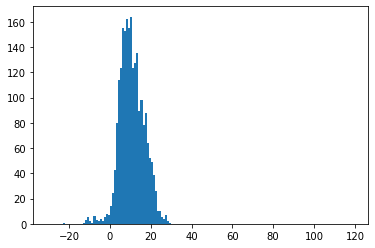

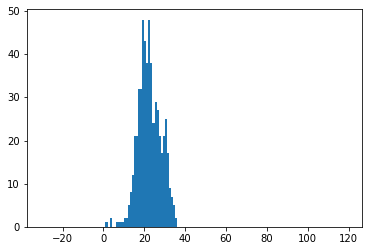

/var/folders/mj/f780t1f175j8s3hb2g3mm24h0000gn/T/ipykernel_7353/1716943745.py:8: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(np.arange(-29.5,119.5,1),dr/norm_dr)
/var/folders/mj/f780t1f175j8s3hb2g3mm24h0000gn/T/ipykernel_7353/1716943745.py:8: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(np.arange(-29.5,119.5,1),dr/norm_dr)


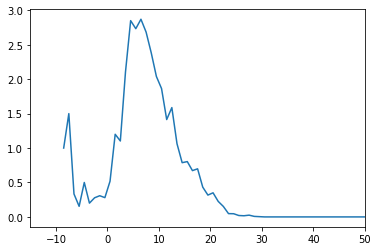

In [199]:
dr,a,b = plt.hist(sum(intrinsic_r_,[]),bins=np.arange(-30,120,1))
plt.show()
plt.hist(spherical_r,bins=np.arange(-30,120,1))
plt.show()
norm_dr,a,b = plt.hist(sum(norm_intrinsic_r_,[]),bins=np.arange(-30,120,1))
# plt.hist(norm_spherical_r)
plt.close()
plt.plot(np.arange(-29.5,119.5,1),dr/norm_dr)
plt.xlim([-15,50])
plt.show()

In [190]:
np.mean([i[0] for i in core_rad_]),np.mean([i[1] for i in core_rad_])

(14.763706833976467, 4.150709167901279)